FYS-STK project 2\
By David Svejda, Gianmarco Puleo and Henrik Breitenstein

All of the results are generated from scripts in this file

# Finding suitable parameter values

We start by optimising the learningrate, the number of epochs and the regularisation parameter lambda for stochastic gradient descent. First we optimise the learning rate and number of epoch with a small regularisation parameter by looking at how the accuracy and cross-entropy changes based on the parameters.

In [1]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import numpy as np
import Data
import ActivationFunctions as AF
import plot

## Momentum

Before optimizing the learning rate and number of epochs we need a suitable momentum. To find this we do a small test of different values:

In [2]:
Llist = np.arange(1, 4, 0.5)
Lmd = 1e-4
[lr_range, ep_range] = [np.logspace(-4, 0, 5), np.logspace(1, 2, 5)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
for L in Llist:
    name = None
    print(f'------------- Momentum = {L} -------------')
    hp.Run(L, lr_range, ep_range, 22, train, train_tar, test, test_tar, hp.Cross_Entropy, shapes, AF.SoftMax(), op.MomentumOptimiser, name, Lmd, 0, 0)

------------- Momentum = 1.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 17.78279410038923, Best Acc: 0.9220055710306406, Best CE: 0.15294275613648103
------------- Momentum = 1.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 10.0, Best Acc: 0.9442896935933147, Best CE: 0.14109393359624223
------------- Momentum = 2.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.924791086350975, Best CE: 0.1872213599694304
------------- Momentum = 2.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 31.622776601683793, Best Acc: 0.924791086350975, Best CE: 0.18911837407921217
------------- Momentum = 3.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 10.0, Best Acc: 0.9080779944289693, Best CE: 0.2138984100702457
------------- Momentum = 3.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.947075208913649, Best CE: 0.1602014780133041


Where we choose $\text{Momentum} = 1.5$ since this had the best accuracy.

## Learning Rate Schedule

For optimizing parameters together with a learning rate schedule we first do a test on a smaller range of parameters to find a suitable value for the number of steps before the learning rate is halved. 

In [10]:
Llist = [0, 1.5] #Momentum
Lmd = 1e-4
[lr_range, ep_range, t1] = [np.logspace(-4, 0, 5), np.logspace(1, 2, 5), np.logspace(3, 2, 10)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
schedules = [lrs.hyperbolic_lr, lrs.linear_lr, lrs.exponential_lr]
opts = [op.Optimiser, op.MomentumOptimiser]
for n, opt in enumerate(opts):
    print(opt.__name__)
    for schedule in schedules:
        print(f'{schedule.__name__:-^20}')
        for t in t1:
            name = None
            print(f'------------- t1 = {t} -------------')
            hp.Run(Llist[n], lr_range, ep_range, 22, train, train_tar, test, test_tar, hp.Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd, t, schedule)


Optimiser
---hyperbolic_lr----
------------- t1 = 1000.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 31.622776601683793, Best Acc: 0.9387186629526463, Best CE: 0.15966933370123856
------------- t1 = 774.263682681127 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.935933147632312, Best CE: 0.16003433002200568
------------- t1 = 599.4842503189409 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.924791086350975, Best CE: 0.16846270995504561
------------- t1 = 464.15888336127773 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.924791086350975, Best CE: 0.18450111207549996
------------- t1 = 359.38136638046257 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.9442896935933147, Best CE: 0.12441507540991674
------------- t1 = 278.2559402207126 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.234132

.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.0001 , Epochs: 10.0, Best Acc: 0.17548746518105848, Best CE: 5.194877015751224
------------- t1 = 129.1549665014884 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.0001 , Epochs: 17.78279410038923, Best Acc: 0.19498607242339833, Best CE: 6.277686481013536
------------- t1 = 100.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 1.0 , Epochs: 10.0, Best Acc: 0.298050139275766, Best CE: 5.594926275176305
---exponential_lr---
------------- t1 = 1000.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.9303621169916435, Best CE: 0.17355724215106857
------------- t1 = 774.263682681127 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.9136490250696379, Best CE: 0.15106861401283164
------------- t1 = 599.4842503189409 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.9220055710306406, Best CE: 0.20915393647682354
------------- t1 

Whith the one best results being

Normal optimiser:

**hyperbolic schedule:** $\Theta = 215$ 

With momentum:

**hyperbolic schedule:** $\Theta = 464$


## Optimising the learning rate and the number of epochs
We are then ready to do the optimazation for five different optimisers: Momentum Optimiser, AdaGrad, Adam, RMSProp and Learning Rate Schedule optimiser. First we take a look at the results from each optimization step for the optimiser with momentum. The momentum was set to $1.5$ after testing a small range of momentums. With theregularisation parameter set to $\lambda = 10^{-4}$ we get the following heat map for accuracy and cross-entropy respectivly.

In [5]:
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4

In [ ]:
#Optimiser
hp.SendToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'Optimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.046415888336127774 , Epochs: 464.15888336127773, Best Acc: 0.9303621169916435, Best CE: 0.15324268502567187

In [ ]:
#MomentumOptimiser
hp.SendToLrEpoch(1.5, 464, lrs.hyperbolic_lrs, op.MomentumOptimiser, lr_range, ep_range, Lmd, 'MomentumOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.046415888336127774 , Epochs: 1000.0, Best Acc: 0.9387186629526463, Best CE: 0.1310497302793841

In [6]:
#AdaGradOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.046415888336127774 , Epochs: 464.15888336127773, Best Acc: 0.7966573816155988, Best CE: 1.1940330588391206


In [ ]:
#AdamOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.000774263682681127 , Epochs: 599.4842503189409, Best Acc: 0.958217270194986, Best CE: 0.08720002237414619

In [ ]:
#RMSPropOptimiser
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.000774263682681127 , Epochs: 1000.0, Best Acc: 0.9526462395543176, Best CE: 0.09332666614550918

We plot them:

In [12]:
from plot import *
import os

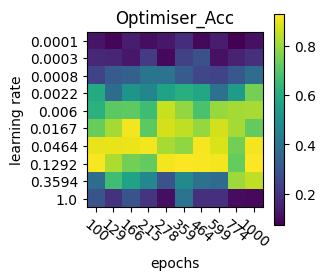

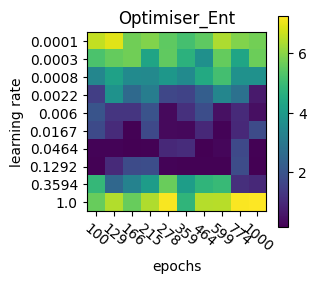

In [13]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.1$ and Epochs $= 100$.

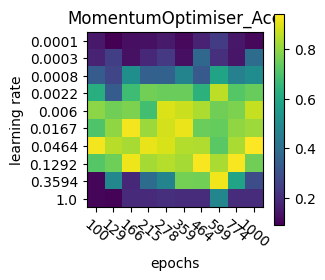

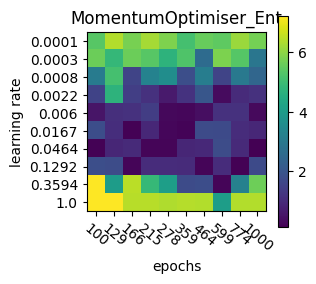

In [18]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.046$ and Epochs $= 100$.

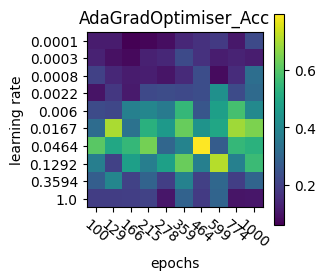

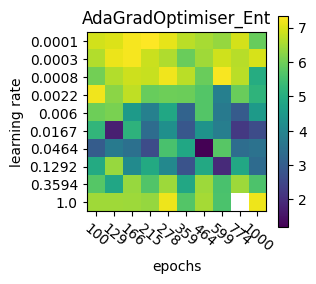

In [17]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.05$ and Epochs $= 470$.

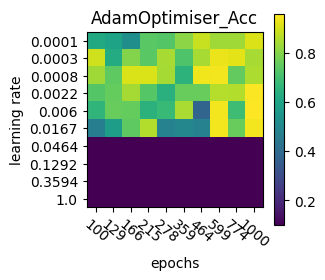

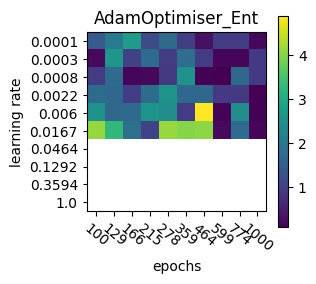

In [16]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.0008$ and Epochs $= 600$.

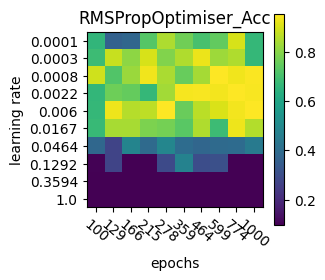

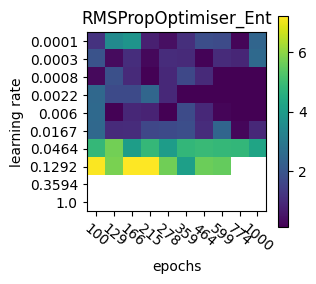

In [14]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.0022$ and Epochs $= 780$.

## Optimising Lambda

With these we optimize for the regularisation parameter $\lambda$

In [3]:
#Optimiser Momentum, Lr, Epochs, t1
hp.SendToLambda(0, 0.1, 100, 215, op.Optimiser, lrs.hyperbolic_lr)

..................................................

Lmd: 0.001, Best Acc: 0.935933147632312, Best CE: 0.935933147632312


In [4]:
#MomentumOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(1.5, 0.046, 100, 464, op.MomentumOptimiser, lrs.hyperbolic_lr)

..................................................

Lmd: 0.0005689866029018293, Best Acc: 0.9442896935933147, Best CE: 0.9442896935933147


In [2]:
#AdaGradOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 0.05, 470, 0, op.AdaGradOptimiser, 0)

..................................................

Lmd: 0.00013894954943731373, Best Acc: 0.9080779944289693, Best CE: 0.8969359331476323


In [6]:
#AdamOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 8e-4, 600, 0, op.AdamOptimiser, 0)

..................................................

Lmd: 0.0008286427728546842, Best Acc: 0.9554317548746518, Best CE: 0.9554317548746518


In [7]:
#RMSPropOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 0.0022, 780, 0, op.RMSPropOptimiser, 0)

..................................................

Lmd: 0.0007543120063354615, Best Acc: 0.9526462395543176, Best CE: 0.9526462395543176


We then plot the result

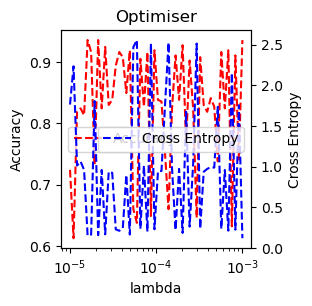

In [11]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 3*10^{-5}$ for the normal optimiser.

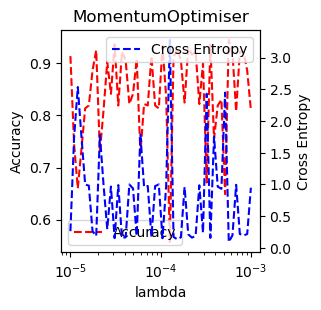

In [12]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 4*10^{-5}$ for optimiser with momentum.

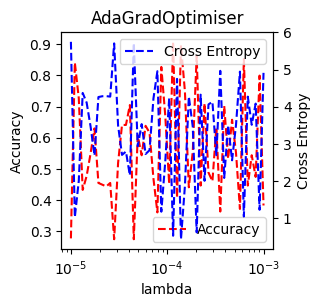

In [4]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 2*10^{-5}$ for AdaGradOptimiser.

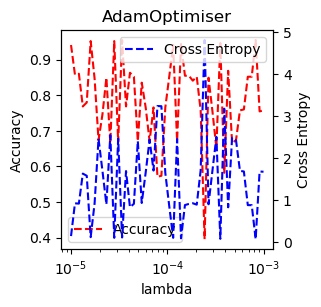

In [14]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 3*10^{-5}$ for AdamOptimiser.

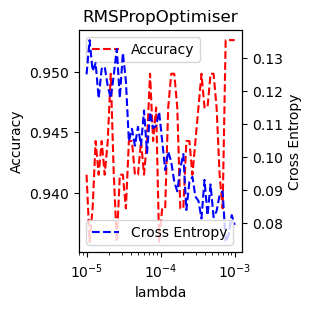

In [16]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 10^{-3}$ for RMSPropOptimiser.

With these we can now do another scan of the learning rate and number of epochs.

In [5]:
[lr_range, ep_range] = [np.logspace(-2, 0, 10), np.logspace(1, 2.5, 10)]
#Optimiser
Lmd = 3e-5
hp.SendToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'OptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.3593813663804626 , Epochs: 100.0, Best Acc: 0.7325905292479109, Best CE: 1.9659763653293258


In [6]:
[lr_range, ep_range] = [np.logspace(-2, -1, 10), np.logspace(1, 2.5, 10)]
Lmd = 4e-5
#MomentumOptimiser
hp.SendToLrEpoch(0, 464, lrs.hyperbolic_lr, op.MomentumOptimiser, lr_range, ep_range, Lmd, 'MomentumOptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.1 , Epochs: 68.12920690579611, Best Acc: 0.6991643454038997, Best CE: 2.100653351542234


In [ ]:
[lr_range, ep_range] = [np.logspace(-3, -1, 10), np.logspace(1, 2.5, 10)] #10^2.5 approx 300
Lmd = 2e-5
#AdaGradOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiserNr2')

In [ ]:
[lr_range, ep_range] = [np.logspace(-4, -3, 10), np.logspace(2.6, 2.9, 10)]
Lmd = 3e-5
#AdamOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiserNr2')

In [ ]:
[lr_range, ep_range] = [np.logspace(-3, -2, 10), np.logspace(2.8, 3, 10)] #10^2.8 = 630
Lmd = 1e-3
#RMSPropOptimiser
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiserNr2')

We then plot them

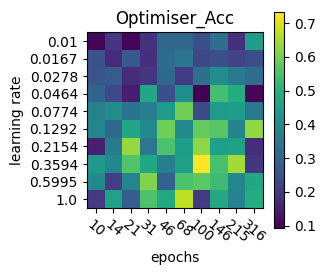

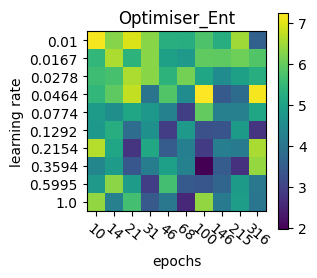

In [19]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

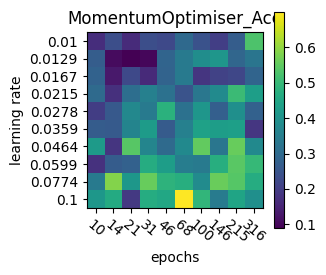

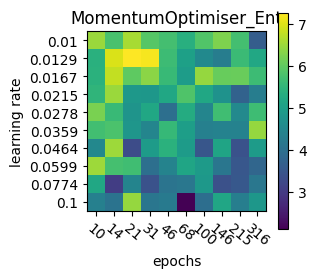

In [20]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

# One hidden layer

We have studied the performance of the Logistic regression, but now we want to see if we can do better with a \"real\" neural net. We add a hidden layer with 25 nodes, because 25 is about half way between 10 and 64, geometrically.

In [1]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import numpy as np
import Data
import ActivationFunctions as AF
import plot


In [2]:
import Hyper as hp
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
#Optimiser
# hp.NetworkToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'Optimiser_ReLU'   , AF.ReLU()         , (64, 25, 10))
# hp.NetworkToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'Optimiser_Leaky'  , AF.LeakyReLU(1e-2), (64, 25, 10))
hp.NetworkToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'Optimiser_sigmoid', AF.Sigmoid()      , (64, 25, 10))

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 1.0 , Epochs: 774.263682681127, Best Acc: 0.924791086350975, Best CE: 0.1058246703012895


FileNotFoundError: [Errno 2] No such file or directory: './Data/NrHidden1/Optimiser/LrEpoch/Acc_Optimiser_sigmoid.npy'

In [ ]:
#MomentumOptimiser
hp.SendToLrEpoch(1.5, 464, lrs.hyperbolic_lrs, op.MomentumOptimiser, lr_range, ep_range,
                 Lmd, 'MomentumOptimiser_ReLU'   , AF.ReLU()         , (64, 25, 10))
hp.SendToLrEpoch(1.5, 464, lrs.hyperbolic_lrs, op.MomentumOptimiser, lr_range, ep_range,
                 Lmd, 'MomentumOptimiser_Leaky'  , AF.LeakyReLU(1e-2), (64, 25, 10))
hp.SendToLrEpoch(1.5, 464, lrs.hyperbolic_lrs, op.MomentumOptimiser, lr_range, ep_range,
                 Lmd, 'MomentumOptimiser_sigmoid', AF.Sigmoid()      , (64, 25, 10))

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.046415888336127774 , Epochs: 1000.0, Best Acc: 0.9387186629526463, Best CE: 0.1310497302793841

In [ ]:
#AdaGradOptimiser
hp.SendToLrEpoch(0, 0, 0, op.Optimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiser_ReLU'   , AF.ReLU()         , (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.Optimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiser_Leaky'  , AF.LeakyReLU(1e-2), (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.Optimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiser_sigmoid', AF.Sigmoid()      , (64, 25, 10))

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.016681005372000592 , Epochs: 129.1549665014884, Best Acc: 0.883008356545961, Best CE: 0.23565614194406612

In [ ]:
#AdamOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiser_ReLU'   , AF.ReLU()         , (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiser_Leaky'  , AF.LeakyReLU(1e-2), (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiser_sigmoid', AF.Sigmoid()      , (64, 25, 10))

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.000774263682681127 , Epochs: 599.4842503189409, Best Acc: 0.958217270194986, Best CE: 0.08720002237414619

In [ ]:
#RMSPropOptimiser
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiser_ReLU'   , AF.ReLU()         , (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiser_Leaky'  , AF.LeakyReLU(1e-2), (64, 25, 10))
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiser_sigmoid', AF.Sigmoid()      , (64, 25, 10))

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,
Lr: 0.000774263682681127 , Epochs: 1000.0, Best Acc: 0.9526462395543176, Best CE: 0.09332666614550918